In [3]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from glob import glob # pour trouver les fichiers de tracking
import multiprocessing # pour le traitement parallèle
from functools import partial # pour faciliter l'utilisation de la fonction avec des arguments partiels
#import ffmpeg
from pyproj import Transformer
from scipy.optimize import linear_sum_assignment

### Les données LPS

In [ ]:
"""fusion_3 = "../../DATABASE/basket/LPS/3_fusion.csv"
fusion_4 = "../../DATABASE/basket/LPS/4_fusion.csv"
fusion_5 = "../../DATABASE/basket/LPS/5_fusion.csv"
fusion_7 = "../../DATABASE/basket/LPS/7_fusion.csv"
fusion_10 = "../../DATABASE/basket/LPS/10_fusion.csv"
fusion_15 = "../../DATABASE/basket/LPS/15_fusion.csv"
fusion_16 = "../../DATABASE/basket/LPS/16_fusion.csv"
fusion_21 = "../../DATABASE/basket/LPS/21_fusion.csv"
fusion_22 = "../../DATABASE/basket/LPS/22_fusion.csv"
fusion_23 = "../../DATABASE/basket/LPS/23_fusion.csv"
fusion_29 = "../../DATABASE/basket/LPS/29_fusion.csv
lps_3 = pd.read_csv(fusion_3, sep=";")
lps_4 = pd.read_csv(fusion_4, sep=";")
lps_5 = pd.read_csv(fusion_5, sep=";")
lps_7 = pd.read_csv(fusion_7, sep=";")
lps_10 = pd.read_csv(fusion_10, sep=";")
lps_15 = pd.read_csv(fusion_15, sep=";")
lps_16 = pd.read_csv(fusion_16, sep=";")
lps_21 = pd.read_csv(fusion_21, sep=";")
lps_22 = pd.read_csv(fusion_22, sep=";")
lps_23 = pd.read_csv(fusion_23, sep=";")
lps_29 = pd.read_csv(fusion_29, sep=";")"""

'fusion_3 = "../../DATABASE/basket/LPS/3_fusion.csv"\nfusion_4 = "../../DATABASE/basket/LPS/4_fusion.csv"\nfusion_5 = "../../DATABASE/basket/LPS/5_fusion.csv"\nfusion_7 = "../../DATABASE/basket/LPS/7_fusion.csv"\nfusion_10 = "../../DATABASE/basket/LPS/10_fusion.csv"\nfusion_15 = "../../DATABASE/basket/LPS/15_fusion.csv"\nfusion_16 = "../../DATABASE/basket/LPS/16_fusion.csv"\nfusion_21 = "../../DATABASE/basket/LPS/21_fusion.csv"\nfusion_22 = "../../DATABASE/basket/LPS/22_fusion.csv"\nfusion_23 = "../../DATABASE/basket/LPS/23_fusion.csv"\nfusion_29 = "../../DATABASE/basket/LPS/29_fusion.csv\nlps_3 = pd.read_csv(fusion_3, sep=";")\nlps_4 = pd.read_csv(fusion_4, sep=";")\nlps_5 = pd.read_csv(fusion_5, sep=";")\nlps_7 = pd.read_csv(fusion_7, sep=";")\nlps_10 = pd.read_csv(fusion_10, sep=";")\nlps_15 = pd.read_csv(fusion_15, sep=";")\nlps_16 = pd.read_csv(fusion_16, sep=";")\nlps_21 = pd.read_csv(fusion_21, sep=";")\nlps_22 = pd.read_csv(fusion_22, sep=";")\nlps_23 = pd.read_csv(fusion_23, s

: 

In [4]:
def load_fusion_files(folder_path):
    fusion_files = glob(os.path.join(folder_path, "*_fusion.csv"))
    dataframes = []
    for file in fusion_files:
        df = pd.read_csv(file, sep=';')
        dataframes.append(df)
    return dataframes

In [5]:
liste_lps = load_fusion_files("../../DATABASE/basket/LPS/")

In [6]:
len(liste_lps)

11

In [7]:
def lps_sample(df):
    df = df.copy()
    df = df[::2]# c'est tout ce qu'il fallait mettre pour échantillonner tous les 2 frames
    return df

def nettoyage_lps(df):
    columns_to_drop = ["lat_brute", "long_brute", "hdop", "vitesse_fusion", "battery"]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    df = lps_sample(df)
    transformer = Transformer.from_crs("epsg:4326", "epsg:2154", always_xy=True)
    df['x'], df['y'] = transformer.transform(df['longitude_fusion'].values, df['latitude_fusion'].values)
    # normalisation centrée réduite
    df['x_norm'] = (df['longitude_fusion'] - df['longitude_fusion'].mean()) / df['longitude_fusion'].std()
    df['y_norm'] = (df['latitude_fusion'] - df['latitude_fusion'].mean()) / df['latitude_fusion'].std()
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    start_time = df['datetime'].iloc[0]
    df['relative_time'] = (df['datetime'] - start_time).dt.total_seconds()
    df = df.dropna(subset=["latitude_fusion", "longitude_fusion"])
    df = df.reset_index(drop=True)
    return df

In [8]:
for i in range(len(liste_lps)):
    liste_lps[i] = nettoyage_lps(liste_lps[i])
lps_dict = {i: df for i, df in enumerate(liste_lps)}

In [9]:
lps_dict = {i: df for i, df in enumerate(liste_lps)}
for i, (name, df) in enumerate(lps_dict.items()):
    print(i, name, df.shape)

0 0 (42865, 9)
1 1 (37337, 9)
2 2 (34447, 9)
3 3 (23928, 9)
4 4 (42394, 9)
5 5 (42473, 9)
6 6 (42855, 9)
7 7 (34224, 9)
8 8 (42344, 9)
9 9 (11972, 9)
10 10 (41474, 9)


In [10]:
lps_dict[1]

,timestamp,latitude_fusion,longitude_fusion,x,y,x_norm,y_norm,datetime,relative_time
0,1702478113100,49.458142,1.062309,559480.326428,6.930472e+06,-0.529600,1.517007,2023-12-13 14:35:13.100,0.0
1,1702478113300,49.458142,1.062309,559480.354252,6.930472e+06,-0.524061,1.517007,2023-12-13 14:35:13.300,0.2
2,1702478113500,49.458142,1.062309,559480.377623,6.930472e+06,-0.519408,1.517007,2023-12-13 14:35:13.500,0.4
3,1702478113700,49.458142,1.062310,559480.396805,6.930472e+06,-0.515589,1.517007,2023-12-13 14:35:13.700,0.6
4,1702478113900,49.458142,1.062310,559480.412340,6.930472e+06,-0.512497,1.517007,2023-12-13 14:35:13.900,0.8
...,...,...,...,...,...,...,...,...,...
37332,1702486859900,49.458049,1.062370,559484.509940,6.930462e+06,0.353939,-0.569194,2023-12-13 17:00:59.900,8746.8
37333,1702486860100,49.458050,1.062369,559484.416894,6.930462e+06,0.334725,-0.540786,2023-12-13 17:01:00.100,8747.0
37334,1702486860300,49.458052,1.062367,559484.308721,6.930462e+06,0.312485,-0.511776,2023-12-13 17:01:00.300,8747.2
37335,1702486860500,49.458053,1.062366,559484.199088,6.930462e+06,0.290064,-0.487284,2023-12-13 17:01:00.500,8747.4


Les fichiers lps ont été enregistrés de 14h35 a 17h01. Donc deux heures 25 min de jeu.

### Les données tracking

In [11]:
tracking_1_1_2_1 = "../../DATABASE/basket/TRACKING/Equipe1_Vague1_Poss2_video_1.txt"
tracking_df = pd.read_csv(tracking_1_1_2_1, names=['frame', 'player_id', 'x', 'y'], sep=",")

In [12]:
tracking_df[:20]

,frame,player_id,x,y
0,0,0,10.738531,2.423311
1,0,1,10.758081,7.556952
2,0,2,9.685260,7.294818
3,0,3,6.877824,9.319980
4,0,4,5.604179,9.292738
5,0,5,6.155215,9.916403
6,0,6,5.952791,5.027121
7,0,7,4.848655,5.576749
8,0,8,7.785098,10.619481
9,1,0,10.793468,2.439122


In [13]:

def tracking_sample(df):
    """
    Échantillonne le DataFrame en gardant une frame sur 5
    """
    df = df.copy()
    unique_frames = sorted(df['frame'].unique())
    selected_frames = unique_frames[::5]
    df = df[df['frame'].isin(selected_frames)]
    return df

def nettoyage_tracking(df):
    df = df.dropna(subset=["x", "y"])
    df = df.reset_index(drop=True)
    df = tracking_sample(df)
    df["time"] = df["frame"] / 25
    df["x"] = df["x"].astype(float)
    df["y"] = df["y"].astype(float)
    df["player_id"] = df["player_id"].astype(int)
    df["frame"] = df["frame"].astype(int)

    df["x_norm"] = df.groupby("player_id")["x"].transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)
    df["y_norm"] = df.groupby("player_id")["y"].transform(lambda y: (y - y.mean()) / y.std() if y.std() > 0 else 0)
    return df

In [14]:
tracking_df =nettoyage_tracking(tracking_df)
tracking_df.reset_index(drop=True)
tracking_df[:16]

,frame,player_id,x,y,time,x_norm,y_norm
0,0,0,10.738531,2.423311,0.0,-2.429077,-1.484317
1,0,1,10.758081,7.556952,0.0,0.883258,-1.001630
2,0,2,9.685260,7.294818,0.0,1.012336,-1.148542
3,0,3,6.877824,9.319980,0.0,0.268986,0.069098
4,0,4,5.604179,9.292738,0.0,1.425671,0.647658
5,0,5,6.155215,9.916403,0.0,1.205802,0.601897
6,0,6,5.952791,5.027121,0.0,0.545485,-0.588441
7,0,7,4.848655,5.576749,0.0,-0.002053,-0.509346
8,0,8,7.785098,10.619481,0.0,0.450887,0.380153
45,5,0,10.852108,2.521917,0.2,-2.294991,-1.458786


In [15]:
tracking_df

,frame,player_id,x,y,time,x_norm,y_norm
0,0,0,10.738531,2.423311,0.0,-2.429077,-1.484317
1,0,1,10.758081,7.556952,0.0,0.883258,-1.001630
2,0,2,9.685260,7.294818,0.0,1.012336,-1.148542
3,0,3,6.877824,9.319980,0.0,0.268986,0.069098
4,0,4,5.604179,9.292738,0.0,1.425671,0.647658
...,...,...,...,...,...,...,...
3282,385,3,5.606390,1.841755,15.4,-0.775416,-1.917293
3283,385,4,0.658973,5.352539,15.4,-2.722745,-2.929088
3284,385,6,2.336708,9.233820,15.4,-2.354843,2.780589
3285,385,7,2.905753,8.886047,15.4,-2.241351,3.329381


In [16]:
joueur_0 = tracking_df[tracking_df["player_id"] == 0]
joueur_0 = joueur_0.reset_index(drop=True)
joueur_0[:20]


,frame,player_id,x,y,time,x_norm,y_norm
0,0,0,10.738531,2.423311,0.0,-2.429077,-1.484317
1,5,0,10.852108,2.521917,0.2,-2.294991,-1.458786
2,10,0,10.846599,2.646704,0.4,-2.301495,-1.426477
3,15,0,11.077645,2.852193,0.6,-2.028728,-1.373272
4,20,0,11.277779,3.008532,0.8,-1.792456,-1.332793
5,25,0,11.309185,3.103925,1.0,-1.755378,-1.308094
6,30,0,11.699689,3.401040,1.2,-1.294360,-1.231166
7,35,0,11.808855,3.543278,1.4,-1.165481,-1.194338
8,40,0,11.792461,3.678334,1.6,-1.184835,-1.159370
9,45,0,12.053783,3.952349,1.8,-0.876325,-1.088422


### Let's test something

### TEST DE LSAP

In [17]:
lps_keys = list(lps_dict.keys())
N = len(lps_keys)
print(f"Nombre de DataFrames LPS : {N}")
print("Clés disponibles :", lps_keys)

Nombre de DataFrames LPS : 11
Clés disponibles : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Les durées de temps de tracking

In [18]:
tracking_times = tracking_df["time"].sort_index().unique()
tracking_times[:10]
n_frames = len(tracking_times)
delta_t = tracking_times[-1] - tracking_times[0]
print(f"Nombre total de frames dans le DataFrame de tracking : {n_frames}")
print(f"Durée totale du tracking : {delta_t:.2f} secondes")

Nombre total de frames dans le DataFrame de tracking : 78
Durée totale du tracking : 15.40 secondes


In [19]:
tracking_grouped = tracking_df.groupby("player_id")
print(f"Nombre de joueurs uniques dans le DataFrame de tracking : {len(tracking_grouped)}")
player_ids = tracking_df["player_id"].unique()
print(f"Identifiants des joueurs : {player_ids}")
tracking_grouped.get_group(0).head(10)

Nombre de joueurs uniques dans le DataFrame de tracking : 9
Identifiants des joueurs : [0 1 2 3 4 5 6 7 8]


,frame,player_id,x,y,time,x_norm,y_norm
0,0,0,10.738531,2.423311,0.0,-2.429077,-1.484317
45,5,0,10.852108,2.521917,0.2,-2.294991,-1.458786
90,10,0,10.846599,2.646704,0.4,-2.301495,-1.426477
135,15,0,11.077645,2.852193,0.6,-2.028728,-1.373272
180,20,0,11.277779,3.008532,0.8,-1.792456,-1.332793
225,25,0,11.309185,3.103925,1.0,-1.755378,-1.308094
270,30,0,11.699689,3.401040,1.2,-1.294360,-1.231166
315,35,0,11.808855,3.543278,1.4,-1.165481,-1.194338
360,40,0,11.792461,3.678334,1.6,-1.184835,-1.159370
405,45,0,12.053783,3.952349,1.8,-0.876325,-1.088422


In [20]:
for i in range(len(player_ids)):
    print(f"Joueur {i} : {len(tracking_grouped.get_group(i))} frames")

Joueur 0 : 52 frames
Joueur 1 : 77 frames
Joueur 2 : 74 frames
Joueur 3 : 78 frames
Joueur 4 : 77 frames
Joueur 5 : 76 frames
Joueur 6 : 78 frames
Joueur 7 : 75 frames
Joueur 8 : 78 frames


In [21]:
valid_player_ids = []
traj_list = []
print(f"Nombre total de frames dans le DataFrame de tracking : {n_frames}")
for pid in player_ids:
    traj = tracking_grouped.get_group(pid).sort_values("time")
    #traj = traj[['time', 'x_norm', 'y_norm']].drop_duplicates("time")
    if len(traj) < 0.75 * n_frames:
        continue
    traj_interp = pd.DataFrame({'time': tracking_times})
    traj_interp = traj_interp.merge(traj, on='time', how='left')
    traj_interp['x_norm'] = traj_interp['x_norm'].interpolate(method='linear', limit_direction='both')
    traj_interp['y_norm'] = traj_interp['y_norm'].interpolate(method='linear', limit_direction='both')
    valid_player_ids.append(pid)
    traj_list.append(traj_interp[['x_norm', 'y_norm']].values)

Nombre total de frames dans le DataFrame de tracking : 78


In [22]:
traj_interp

,time,frame,player_id,x,y,x_norm,y_norm
0,0.0,0,8,7.785098,10.619481,0.450887,0.380153
1,0.2,5,8,7.946441,10.951314,0.531154,0.451679
2,0.4,10,8,7.938828,11.214467,0.527366,0.508400
3,0.6,15,8,8.113730,11.428192,0.614378,0.554468
4,0.8,20,8,8.351532,11.692261,0.732682,0.611387
...,...,...,...,...,...,...,...
73,14.6,365,8,6.366533,1.329759,-0.254831,-1.622211
74,14.8,370,8,6.306074,1.253194,-0.284908,-1.638714
75,15.0,375,8,6.193787,1.205647,-0.340770,-1.648963
76,15.2,380,8,5.780270,1.023469,-0.546489,-1.688231


In [23]:
print(f"Nombre de joueurs valides après interpolation : {len(valid_player_ids)}")

Nombre de joueurs valides après interpolation : 8


In [24]:
for i in range(len(traj_list)):
    print(f"Trajectoire du joueur {valid_player_ids[i]} : \n{i, traj_list[i][:10]}")

Trajectoire du joueur 1 : 
(0, array([[ 0.88325799, -1.00162978],
       [ 0.88309498, -0.98345122],
       [ 0.88567708, -0.98735822],
       [ 0.87806331, -0.97991852],
       [ 0.88195467, -0.84525886],
       [ 0.88160451, -0.81712058],
       [ 0.84987777, -0.71484097],
       [ 0.87220076, -0.80805795],
       [ 0.85514604, -0.80615595],
       [ 0.88435675, -0.83995231]]))
Trajectoire du joueur 2 : 
(1, array([[ 1.01233606, -1.14854192],
       [ 1.02324311, -1.15005087],
       [ 1.06053555, -1.00252652],
       [ 1.06505916, -0.84928448],
       [ 1.02161218, -1.09476539],
       [ 1.04067105, -0.99620067],
       [ 1.0399086 , -0.76025433],
       [ 1.11974364, -0.59851251],
       [ 1.08548807, -0.54334748],
       [ 1.05428788, -0.80598996]]))
Trajectoire du joueur 3 : 
(2, array([[0.26898562, 0.06909799],
       [0.40343327, 0.12544836],
       [0.38947888, 0.25582006],
       [0.38649771, 0.33557778],
       [0.23666404, 0.40676929],
       [0.4943883 , 0.49560771],
     

In [25]:
P = len(valid_player_ids)
tracking_tensor = np.stack(traj_list, axis=0)
print(f"Tenseur de tracking créé avec la forme : {tracking_tensor.shape}")

Tenseur de tracking créé avec la forme : (8, 78, 2)


In [26]:
tracking_tensor.shape[1]

78

In [27]:
cost_matrix = np.full((N, P), np.inf)
cost_matrix

array([[inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf]])

Meilleure methode

In [28]:
results = {}  # (i, j) -> {'mean_dist': float, 'start_time': float}

for i, (name, lps_df) in enumerate(lps_dict.items()):
    lps_times = lps_df['relative_time'].sort_values().unique()

    for t0 in lps_times:
        t_end = t0 + delta_t
        lps_window = lps_df[(lps_df['relative_time'] >= t0) & (lps_df['relative_time'] <= t_end)]

        if len(lps_window) != n_frames:
            continue  # fenêtre incomplète

        lps_traj = lps_window[['x_norm', 'y_norm']].values  # (T, 2)

        # Construire la cost matrix (P joueurs vs 1 LPS)
        dist_matrix = np.zeros((P, 1))  # chaque joueur vs cette LPS

        for j in range(P):
            dists = np.linalg.norm(tracking_tensor[j] - lps_traj, axis=1)
            dist_matrix[j, 0] = dists.mean()

        # LSAP : un seul joueur est affecté à cette LPS (minimisation)
        row_ind, col_ind = linear_sum_assignment(dist_matrix)

        # Pour chaque appariement (ici un seul par fenêtre)
        for j in row_ind:
            key = (i, j)
            new_cost = dist_matrix[j, 0]
            if key not in results or new_cost < results[key]['mean_dist']:
                results[key] = {'mean_dist': new_cost, 'start_time': t0}


In [29]:
lps_times = lps_df['relative_time'].sort_values().unique()

In [30]:
lps_times

array([0.0000e+00, 2.0000e-01, 4.0000e-01, ..., 8.7472e+03, 8.7474e+03,
       8.7476e+03], shape=(41474,))

In [38]:
df[(df['relative_time'] >= 0.0) & (df['relative_time'] <= 15.4)]

,timestamp,latitude_fusion,longitude_fusion,x,y,x_norm,y_norm,datetime,relative_time
0,1702478113100,49.458035,1.062421,559488.137214,6.930460e+06,0.819628,-0.690588,2023-12-13 14:35:13.100,0.0
1,1702478113300,49.458036,1.062415,559487.711266,6.930460e+06,0.740808,-0.671104,2023-12-13 14:35:13.300,0.2
2,1702478113500,49.458036,1.062410,559487.411830,6.930460e+06,0.685422,-0.658339,2023-12-13 14:35:13.500,0.4
3,1702478113700,49.458037,1.062407,559487.183530,6.930461e+06,0.643245,-0.650496,2023-12-13 14:35:13.700,0.6
4,1702478113900,49.458037,1.062405,559486.986881,6.930461e+06,0.606976,-0.646058,2023-12-13 14:35:13.900,0.8
...,...,...,...,...,...,...,...,...,...
73,1702478127700,49.458036,1.062394,559486.251681,6.930460e+06,0.472219,-0.661290,2023-12-13 14:35:27.700,14.6
74,1702478127900,49.458036,1.062394,559486.208807,6.930460e+06,0.464256,-0.658223,2023-12-13 14:35:27.900,14.8
75,1702478128100,49.458037,1.062393,559486.157438,6.930461e+06,0.454715,-0.654563,2023-12-13 14:35:28.100,15.0
76,1702478128300,49.458037,1.062392,559486.101192,6.930461e+06,0.444295,-0.651526,2023-12-13 14:35:28.300,15.2


In [64]:
results_1 = {}  # (i, j) -> {'mean_dist': float, 'start_time': float}
for k, t0 in enumerate(lps_times[:-n_frames]):
    for i, (name, lps_df) in enumerate(lps_dict.items()):
            t_end = t0 + delta_t
            #lps_window = lps_df[(lps_df['relative_time'] >= t0) & (lps_df['relative_time'] <= t_end)]
            lps_window = lps_df[k:k+n_frames]

            if len(lps_window) != n_frames:
                continue  # fenêtre incomplète

            lps_traj = lps_window[['x_norm', 'y_norm']].values
            for j in range(P):
                cost_matrix[i, j] = np.linalg.norm(tracking_tensor[j] - lps_traj)
    row_ind, col_ind  = linear_sum_assignment(cost_matrix)

    results_1[t0] = cost_matrix[row_ind, col_ind].sum()

In [65]:
len(results_1)

41396

In [66]:
results_1

{np.float64(0.0): np.float64(115.8242349149211),
 np.float64(0.2): np.float64(115.81308697035215),
 np.float64(0.4): np.float64(115.81591525705514),
 np.float64(0.6): np.float64(115.8354513092524),
 np.float64(0.8): np.float64(115.88382785862083),
 np.float64(1.0): np.float64(115.94943104346152),
 np.float64(1.2): np.float64(116.00952803699936),
 np.float64(1.4): np.float64(116.01604051118971),
 np.float64(1.6): np.float64(116.04279419280977),
 np.float64(1.8): np.float64(115.94062341644019),
 np.float64(2.0): np.float64(115.86736103182633),
 np.float64(2.2): np.float64(115.82481067329253),
 np.float64(2.4): np.float64(115.81448754914655),
 np.float64(2.6): np.float64(115.83392754155219),
 np.float64(2.8): np.float64(115.88161626654079),
 np.float64(3.0): np.float64(115.95180901933088),
 np.float64(3.2): np.float64(116.03961760608978),
 np.float64(3.4): np.float64(116.1489748946736),
 np.float64(3.6): np.float64(116.26599553838477),
 np.float64(3.8): np.float64(116.38971296546585),
 np

In [70]:
min(results_1.values())

np.float64(96.99712112130817)

In [72]:
min_key = min(results_1, key=results_1.get)
print(f"Clé avec la valeur minimale : {min_key}, Valeur : {results_1[min_key]}")

Clé avec la valeur minimale : 265.8, Valeur : 96.99712112130817


In [ ]:
for i in results_1:
    print(i)

-15.4
-15.200000000000001
-15.0
-14.8
-14.6
-14.4
-14.200000000000001
-14.0
-13.8
-13.6
-13.4
-13.2
-13.0
-12.8
-12.600000000000001
-12.4
-12.2
-12.0
-11.8
-11.600000000000001
-11.4
-11.2
-11.0
-10.8
-10.600000000000001
-10.4
-10.2
-10.0
-9.8
-9.600000000000001
-9.4
-9.2
-9.0
-8.8
-8.600000000000001
-8.4
-8.2
-8.0
-7.800000000000001
-7.6000000000000005
-7.4
-7.200000000000001
-7.0
-6.800000000000001
-6.6
-6.4
-6.200000000000001
-6.0
-5.800000000000001
-5.6
-5.4
-5.200000000000001
-5.0
-4.800000000000001
-4.6
-4.4
-4.200000000000001
-4.0
-3.8000000000000007
-3.5999999999999996
-3.4000000000000004
-3.200000000000001
-3.0
-2.8000000000000007
-2.5999999999999996
-2.4000000000000004
-2.200000000000001
-2.0
-1.8000000000000007
-1.5999999999999996
-1.4000000000000004
-1.200000000000001
-1.0
-0.8000000000000007
-0.5999999999999996
-0.40000000000000036
-0.20000000000000107
0.0
0.1999999999999993
0.40000000000000036
0.5999999999999996
0.7999999999999989
0.9999999999999982
1.200000000000001
1.400

: 

: 

: 

In [ ]:
len(results)

88

: 

: 

: 

In [ ]:
N = len(lps_dict)
P = len(valid_player_ids)
cost_matrix = np.full((N, P), np.inf)
start_time_matrix = np.full((N, P), np.nan)

: 

: 

: 

In [ ]:
for (i, j), values in results.items():
    cost_matrix[i, j] = values['mean_dist']
    start_time_matrix[i, j] = values['start_time']

: 

: 

: 

In [ ]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)
assignments = []
for i, j in zip(row_ind, col_ind):
    cost = cost_matrix[i, j]
    t0 = start_time_matrix[i, j]
    lps_name = list(lps_dict.keys())[i]
    player_id = valid_player_ids[j]
    assignments.append({
        'lps_index': i,
        'lps_name': lps_name,
        'player_index': j,
        'player_id': player_id,
        'cost': cost,
        'start_time': t0
    })
for a in assignments:
    print(f"LPS '{a['lps_name']}' → Joueur {a['player_id']} | coût = {a['cost']:.3f} | t0 = {a['start_time']:.2f}")


LPS '0' → Joueur 1 | coût = 1.008 | t0 = 1392.00
LPS '1' → Joueur 3 | coût = 0.848 | t0 = 1391.40
LPS '3' → Joueur 6 | coût = 0.536 | t0 = 7271.60
LPS '4' → Joueur 5 | coût = 0.836 | t0 = 4212.60
LPS '6' → Joueur 4 | coût = 0.655 | t0 = 5798.00
LPS '7' → Joueur 2 | coût = 0.979 | t0 = 8187.80
LPS '8' → Joueur 8 | coût = 0.764 | t0 = 1327.60
LPS '10' → Joueur 7 | coût = 0.786 | t0 = 8285.00


: 

: 

: 

In [ ]:
assignments_df = pd.DataFrame(assignments)

: 

: 

: 

In [ ]:
assignments_df

,lps_index,lps_name,player_index,player_id,cost,start_time
0,0,0,0,1,1.007989,1392.0
1,1,1,2,3,0.847596,1391.4
2,3,3,5,6,0.536341,7271.6
3,4,4,4,5,0.836123,4212.6
4,6,6,3,4,0.654965,5798.0
5,7,7,1,2,0.979183,8187.8
6,8,8,7,8,0.764137,1327.6
7,10,10,6,7,0.785711,8285.0


: 

: 

: 

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.columns = ['mean_dist', 'start_time']
results_df.reset_index(inplace=True)

: 

: 

: 

In [ ]:
results_df[:88]

,level_0,level_1,mean_dist,start_time
0,0,6,0.766637,6882.6
1,0,5,0.613631,6069.6
2,0,1,1.041265,7456.8
3,0,0,1.007989,1392.0
4,0,2,0.977023,112.4
...,...,...,...,...
83,10,4,0.979420,332.6
84,10,6,0.785711,8285.0
85,10,0,1.048752,4176.8
86,10,1,1.000277,4699.0


: 

: 

: 

Point de départ LPS trouvé à l'index: 10453
Temps de départ LPS: 2023-12-13 15:11:13.700000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 72 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.700000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_0_joueur_3.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_0_joueur_3.gif
Point de départ LPS trouvé à l'index: 9233
Temps de départ LPS: 2023-12-13 15:11:13.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.500000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_1_joueur_8.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_1_joueur_8.gif
Point de départ LPS trouvé à l'index: 7897
Temps de départ LPS: 2023-12-13 15:11:14.100000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:14.100000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_3_joueur_2.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_3_joueur_2.gif
Point de départ LPS trouvé à l'index: 6492
Temps de départ LPS: 2023-12-13 15:11:26.100000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:26.100000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_4_joueur_1.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_4_joueur_1.gif
Point de départ LPS trouvé à l'index: 10399
Temps de départ LPS: 2023-12-13 15:11:13.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 61 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.500000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_5_joueur_7.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_5_joueur_7.gif
Point de départ LPS trouvé à l'index: 10710
Temps de départ LPS: 2023-12-13 15:11:13.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.500000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_7_joueur_6.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_7_joueur_6.gif
Point de départ LPS trouvé à l'index: 10744
Temps de départ LPS: 2023-12-13 15:11:13.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.500000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_8_joueur_5.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_8_joueur_5.gif
Point de départ LPS trouvé à l'index: 7296
Temps de départ LPS: 2023-12-13 15:11:40.100000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:40.100000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_10_joueur_4.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_10_joueur_4.gif
Point de départ LPS trouvé à l'index: 10517
Temps de départ LPS: 2023-12-13 15:11:13.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 78 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:13.500000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_15_joueur_0.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


Animation avec trajectoire spécifique sauvegardée avec succès: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_15_joueur_0.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:376: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Point de départ LPS trouvé à l'index: 7519
Temps de départ LPS: 2023-12-13 15:10:55.500000
Durée maximale du tracking: 15.4 secondes
Données LPS filtrées: 1 points
Création de l'animation avec trajectoire spécifique...
- 78 frames
- Intervalle: 230ms par frame
- Durée estimée: 17.9 secondes
- Joueur Tracking suivi: 0
- Nombre total de joueurs tracking: 9
- Temps de synchronisation t0: 2023-12-13 15:11:14.100000
- Fonctionnalités: Positions tous joueurs + Trajectoire tracking joueur 0 + Trajectoire LPS
Sauvegarde de l'animation: C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_16_joueur_3.gif


c:\Users\Ousmane Kontao\Desktop\Projet_Data\Stage_DynaTeam\notebooks\video_basket.py:365: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  anim.save(output_filename, writer='pillow', fps=1000/interval, dpi=120)


KeyboardInterrupt: 

c:\Users\Ousmane Kontao\Desktop\Projet_Data\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Ousmane Kontao\Desktop\Projet_Data\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


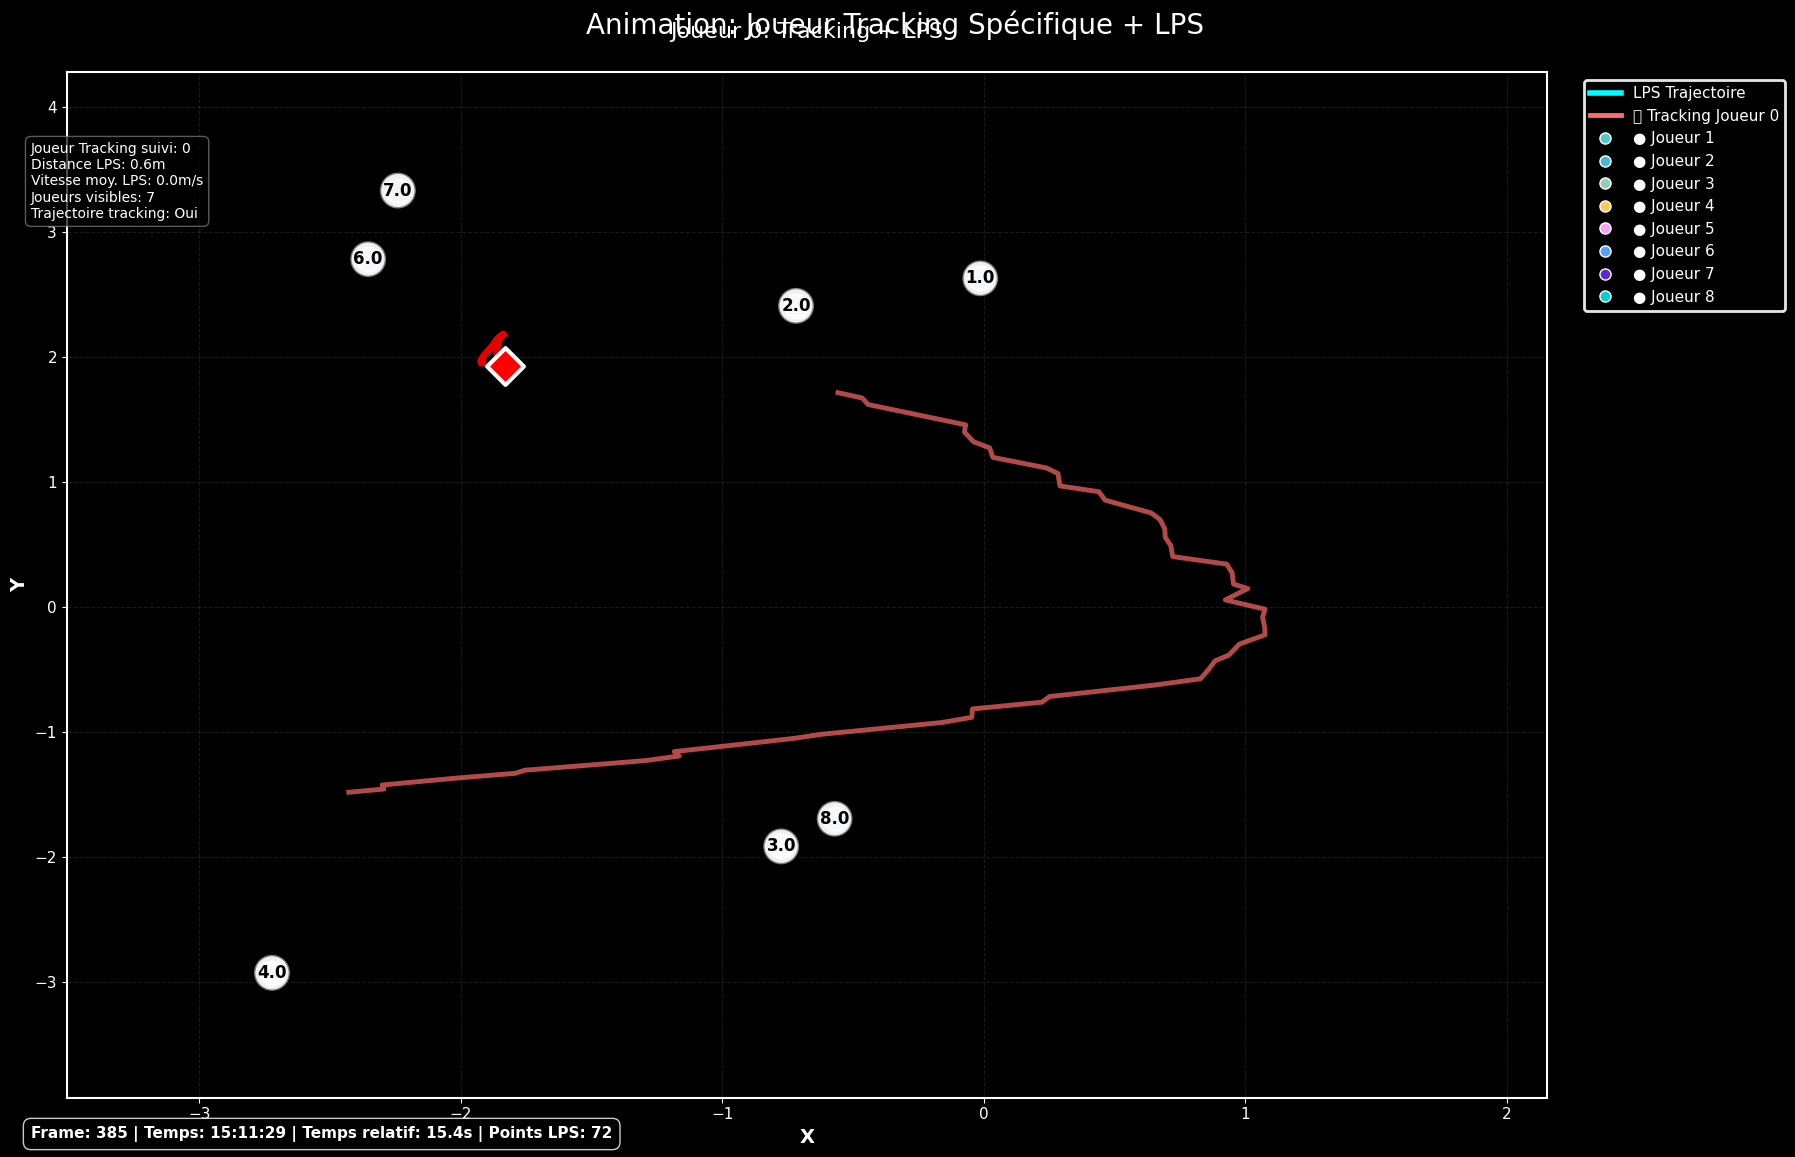

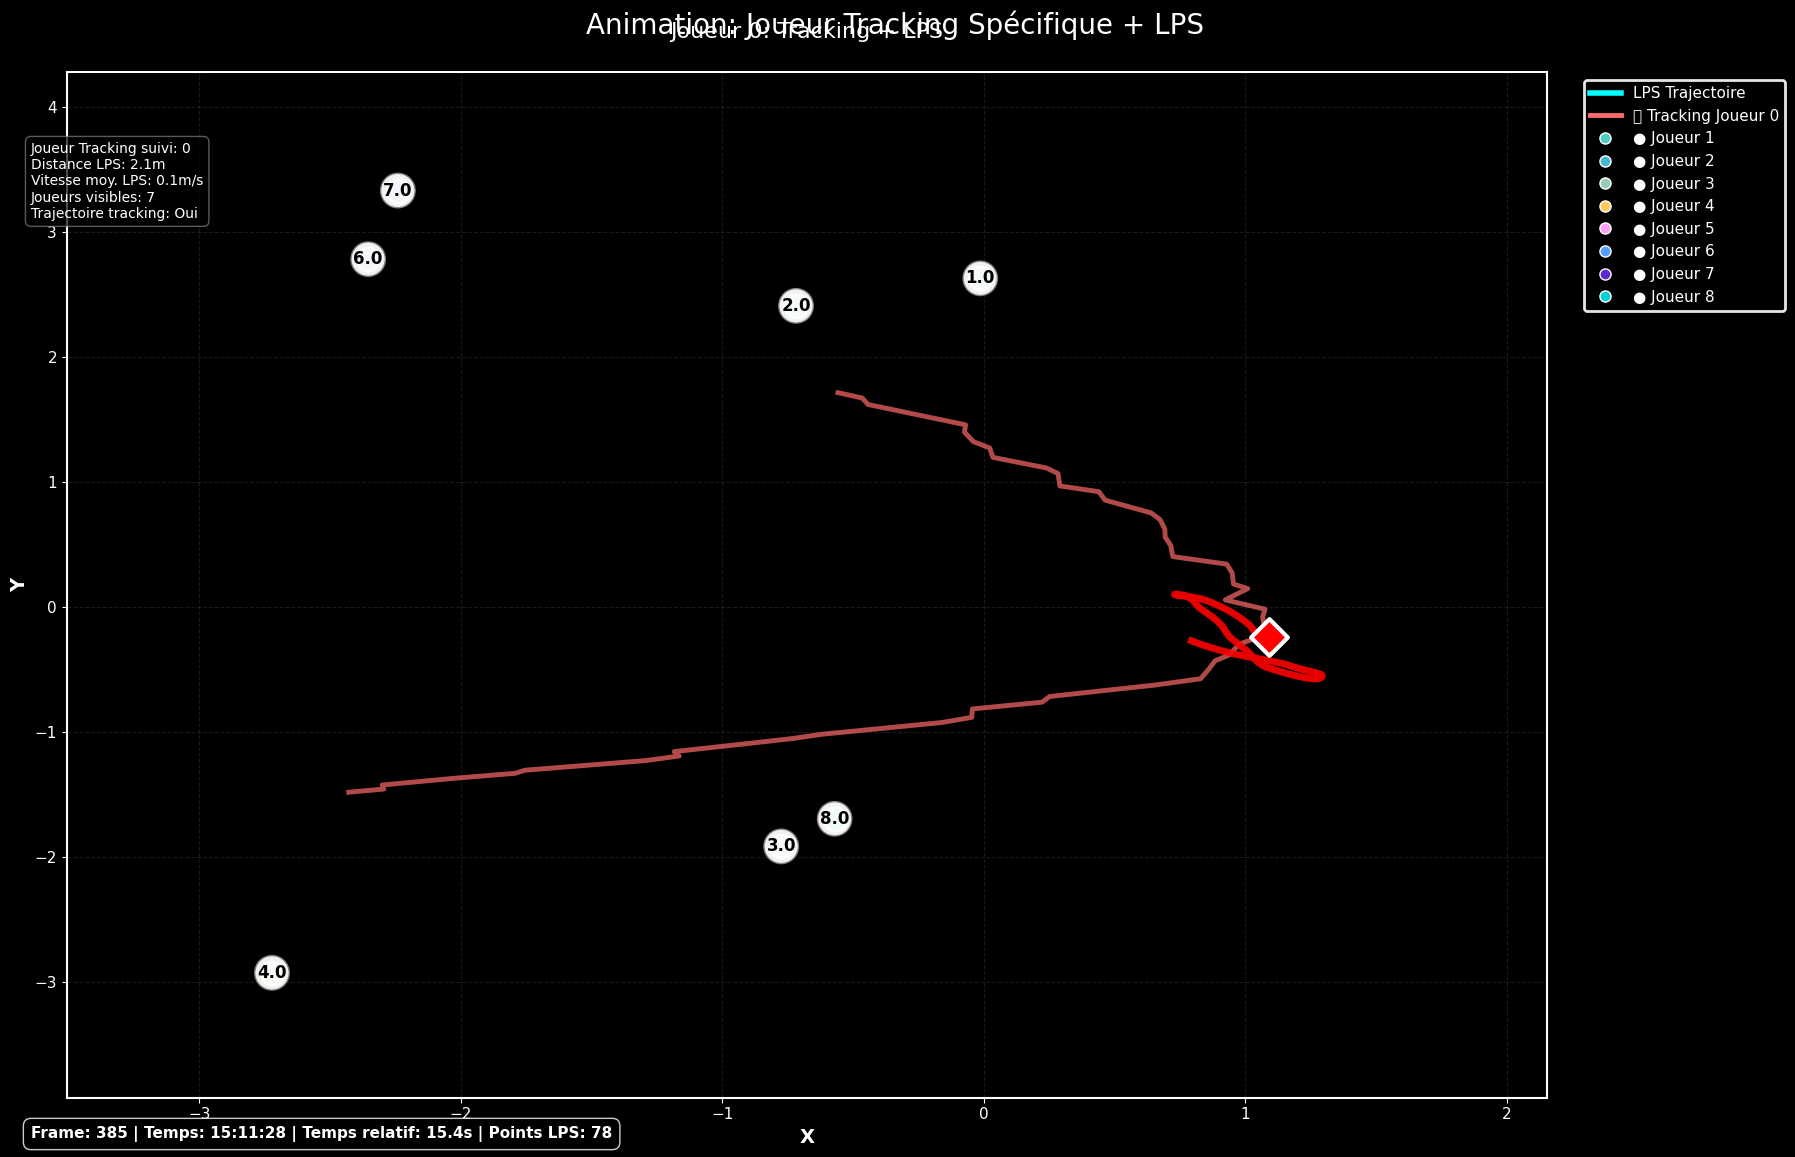

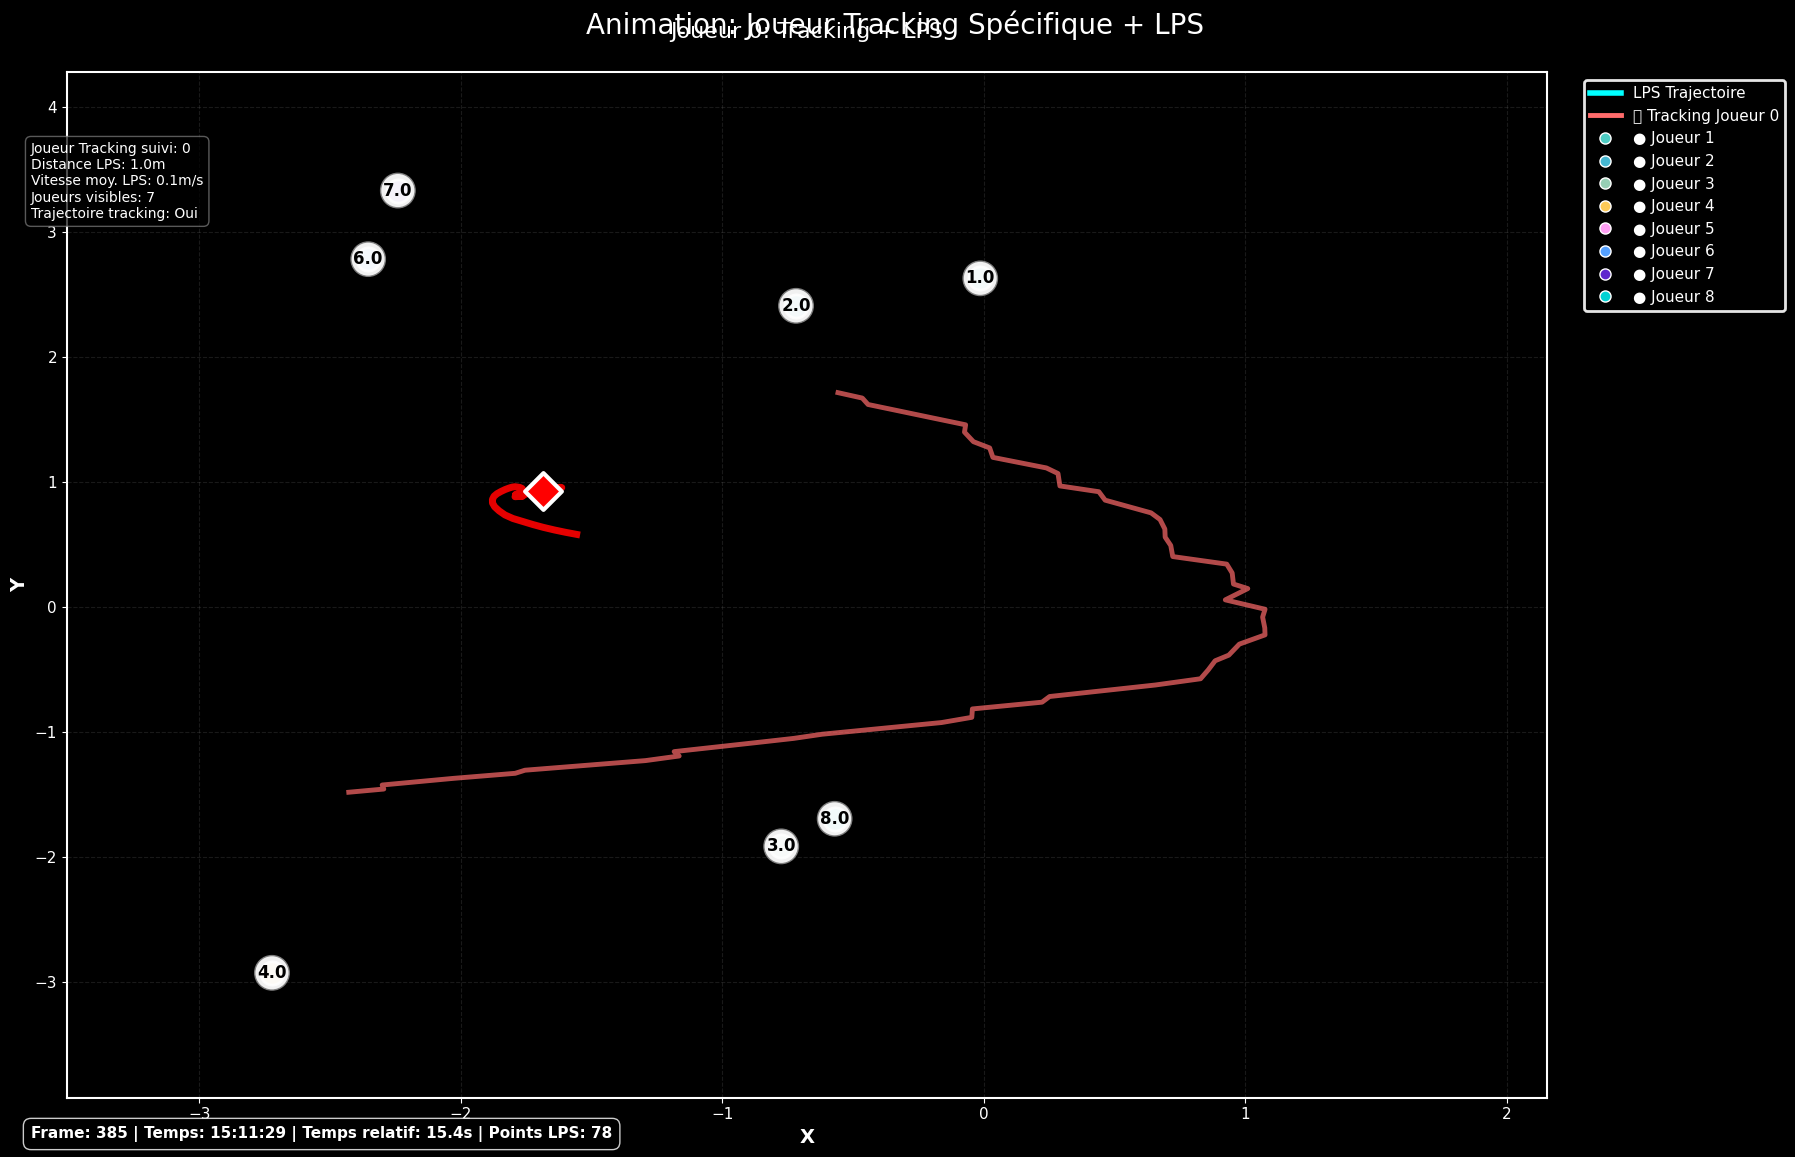

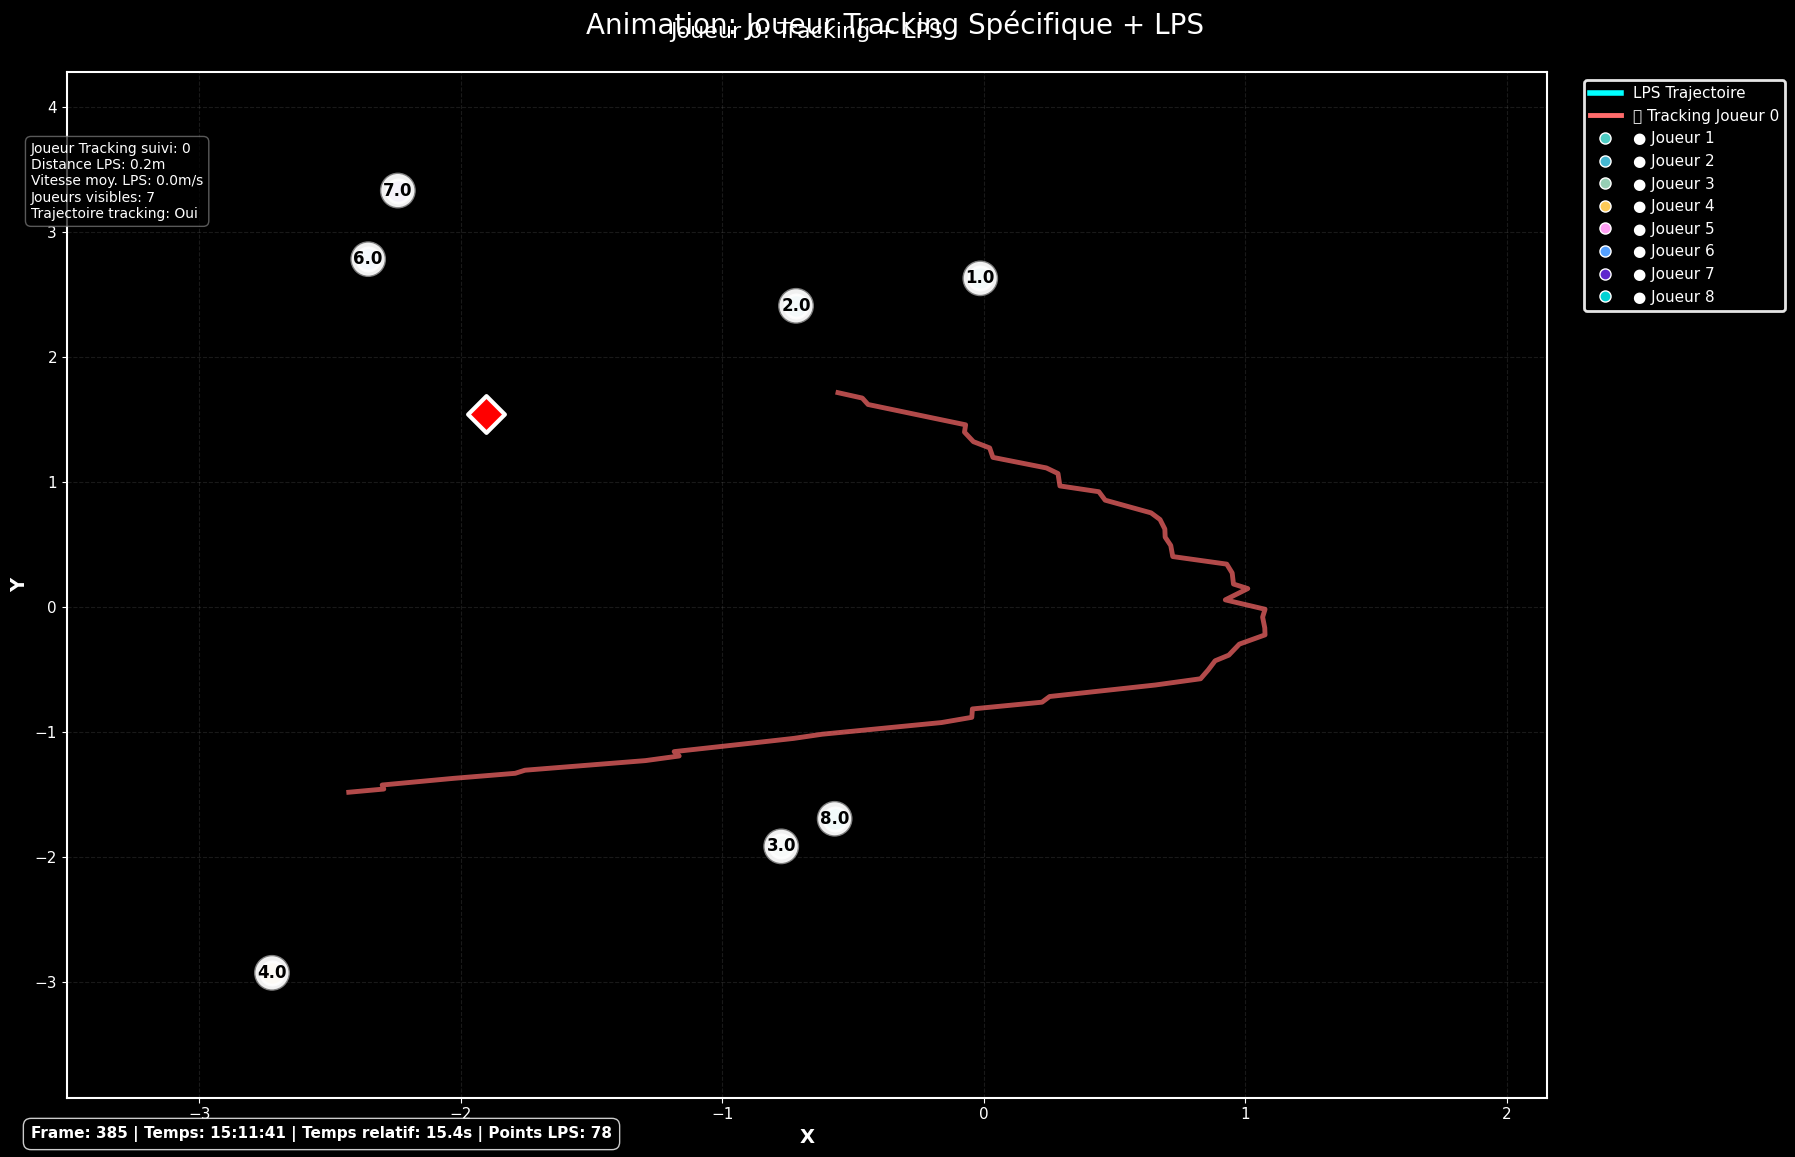

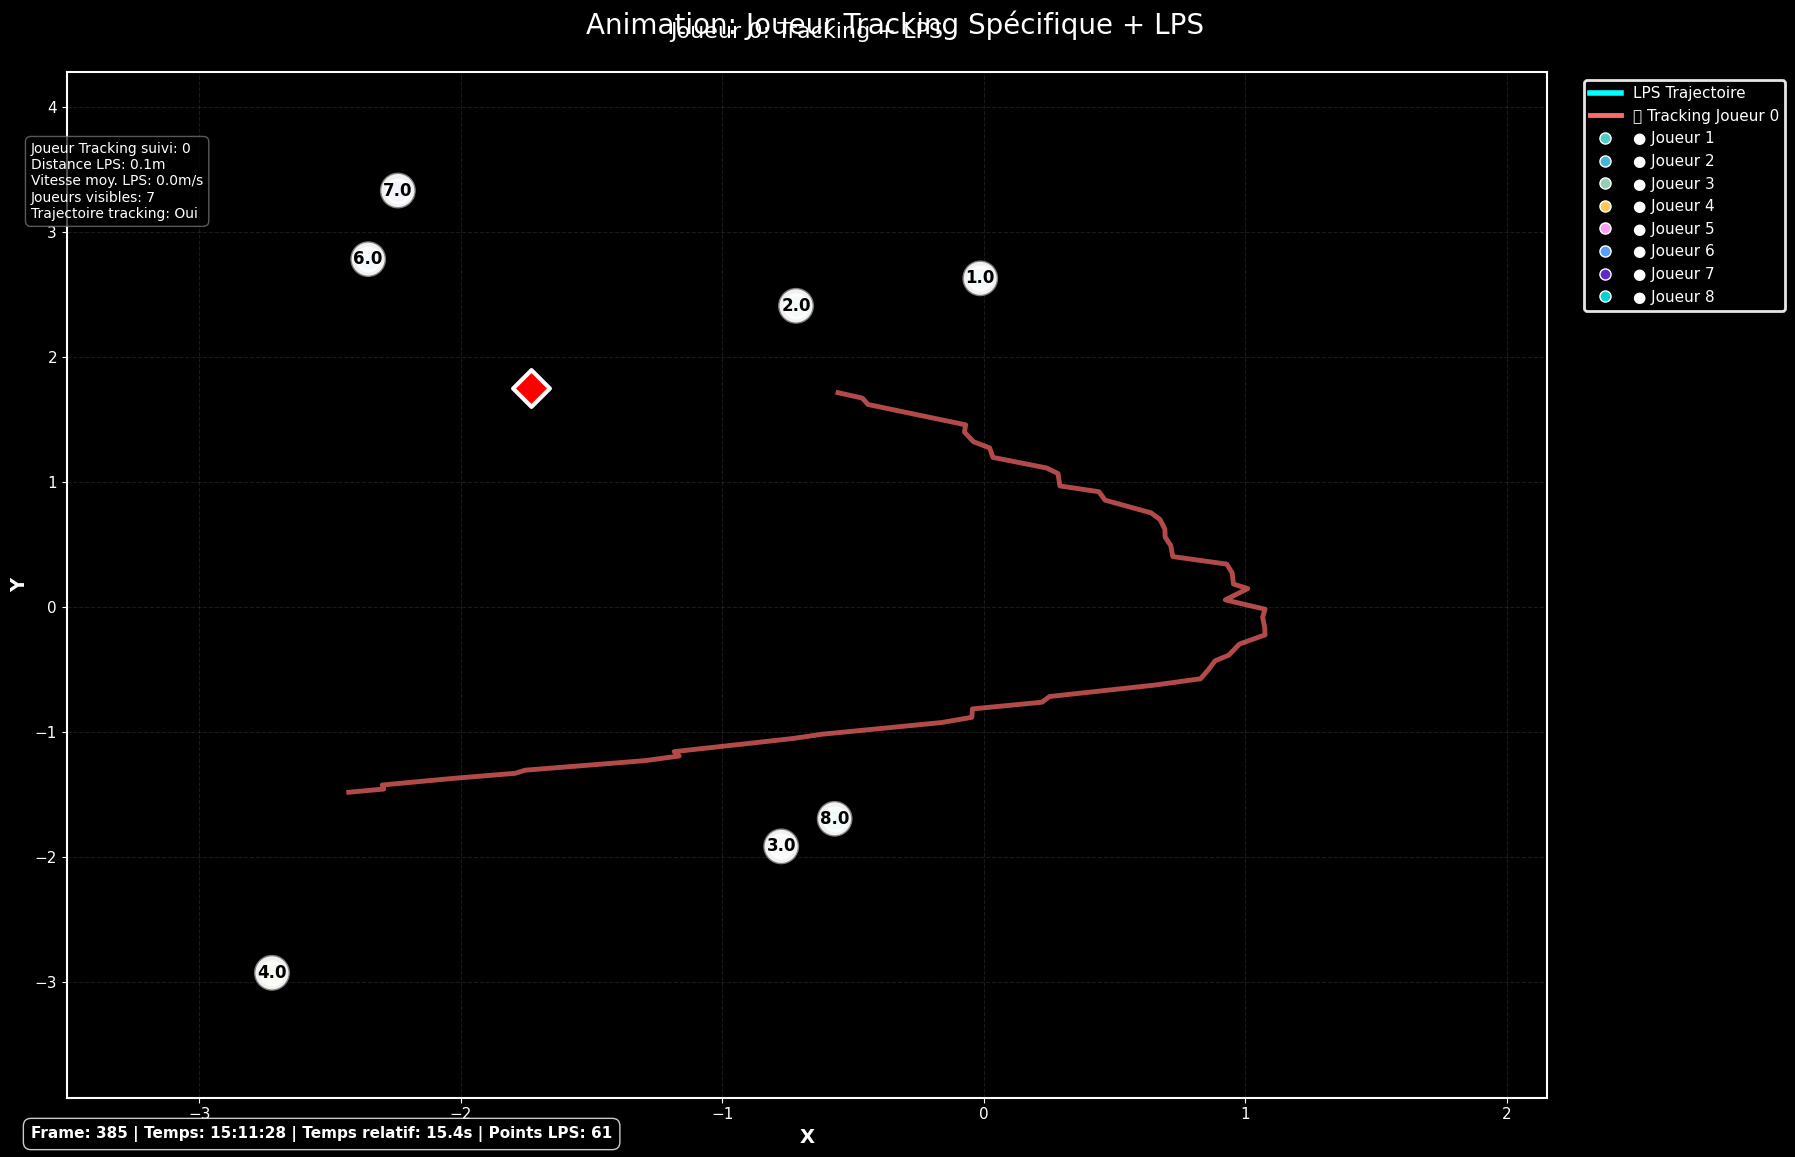

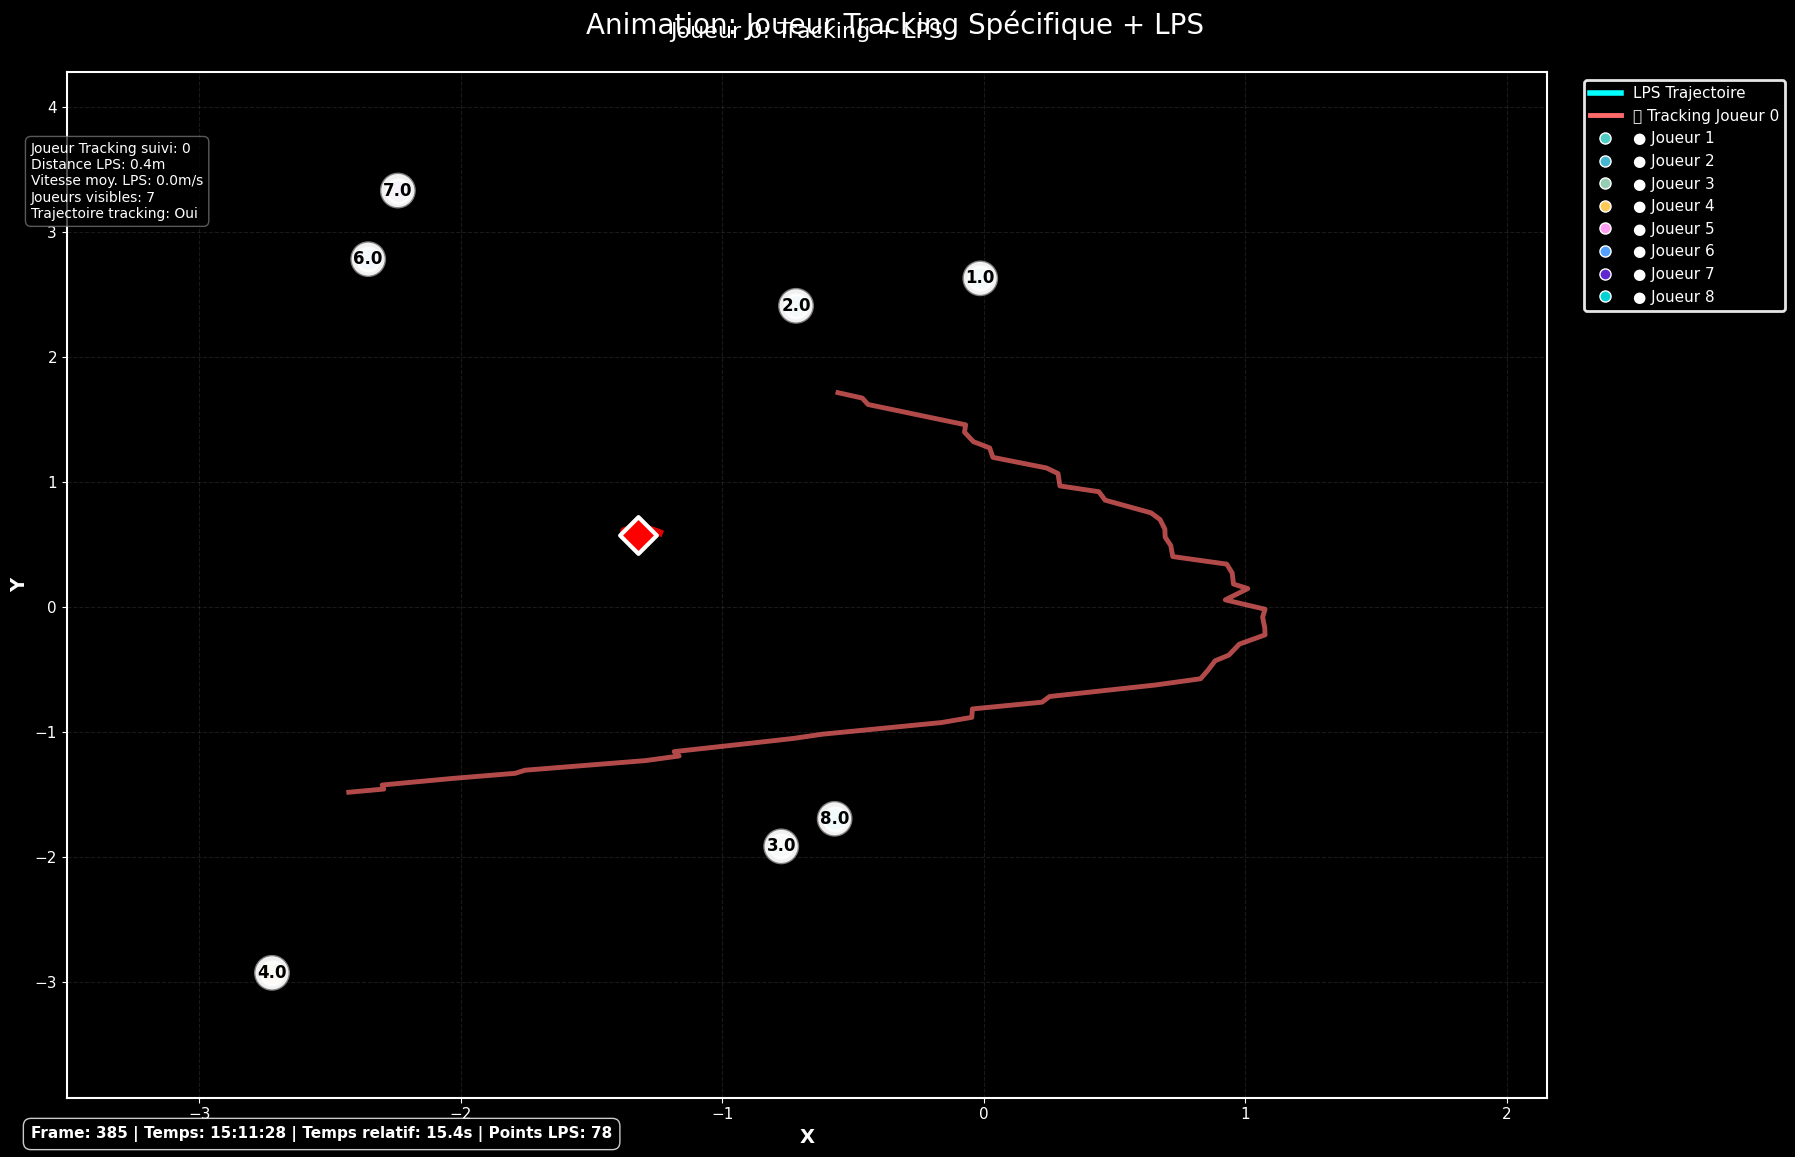

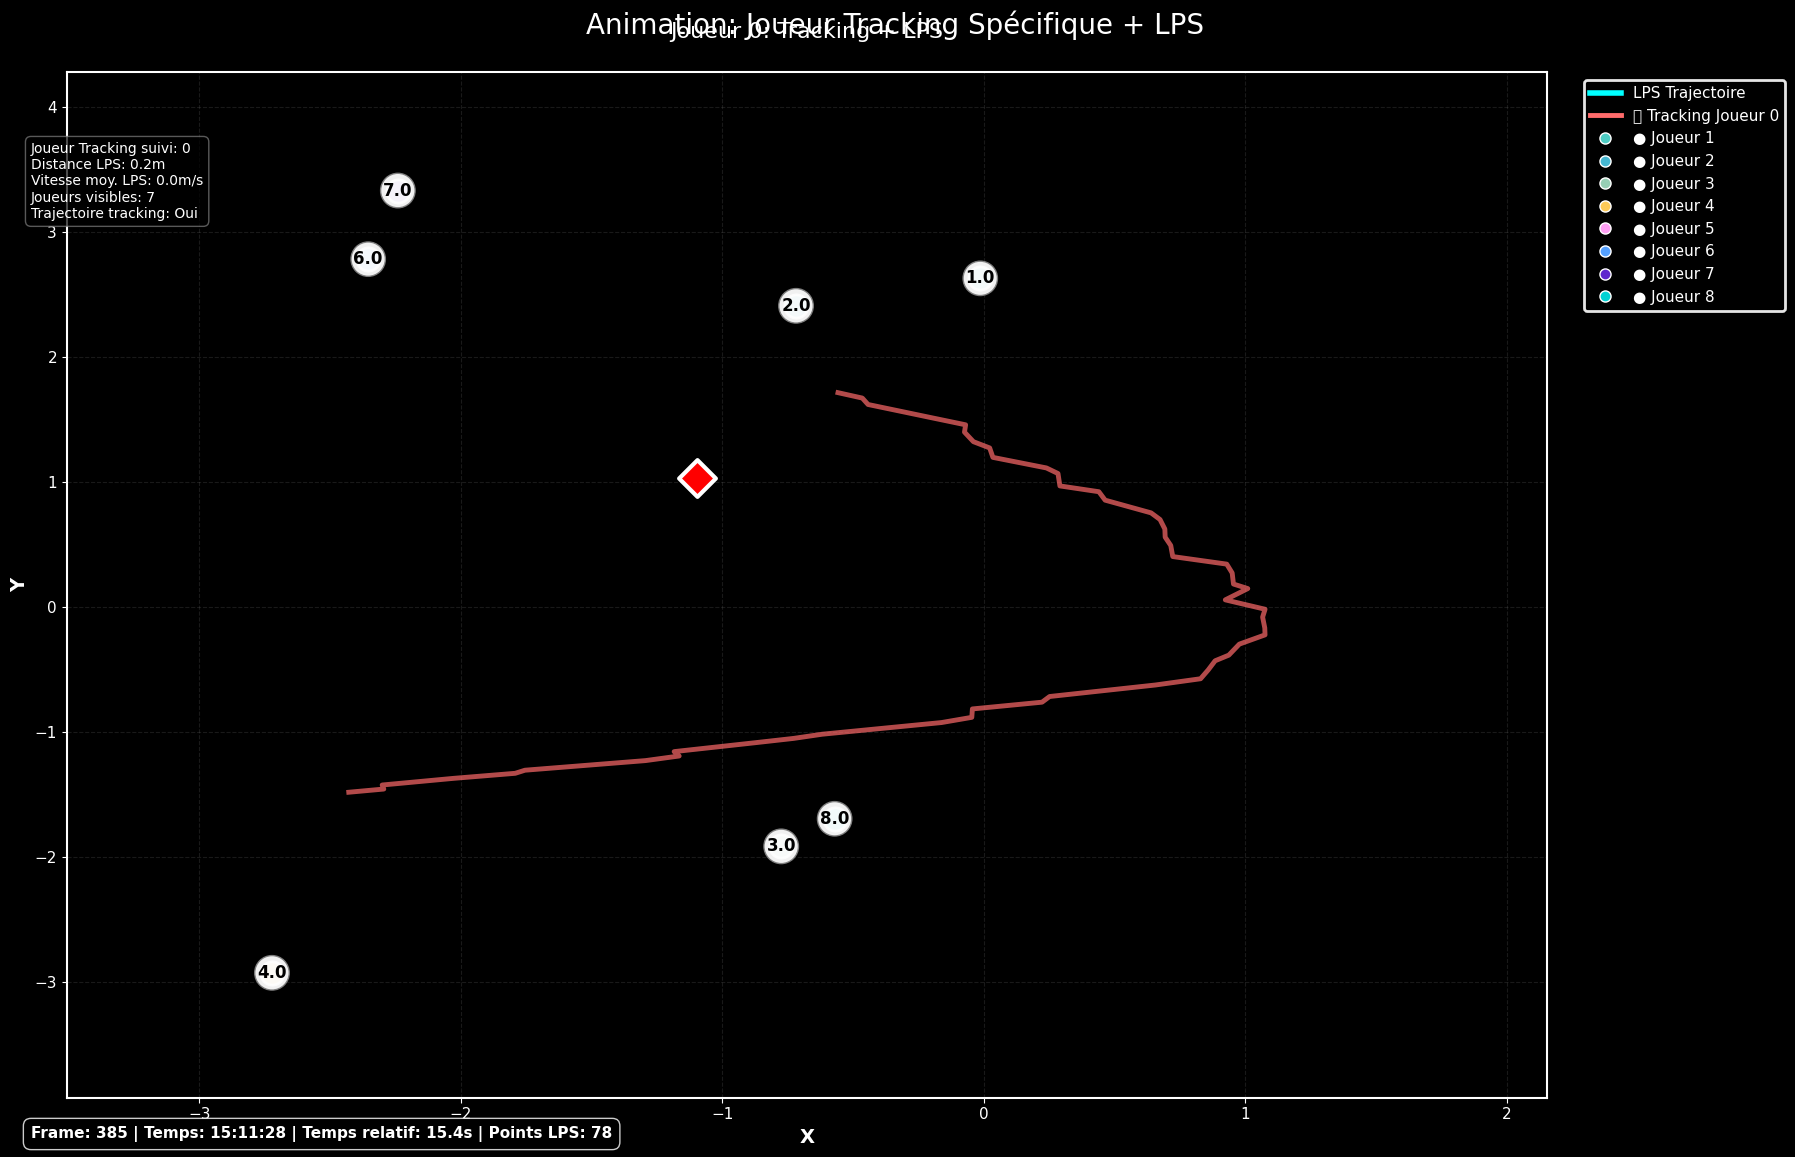

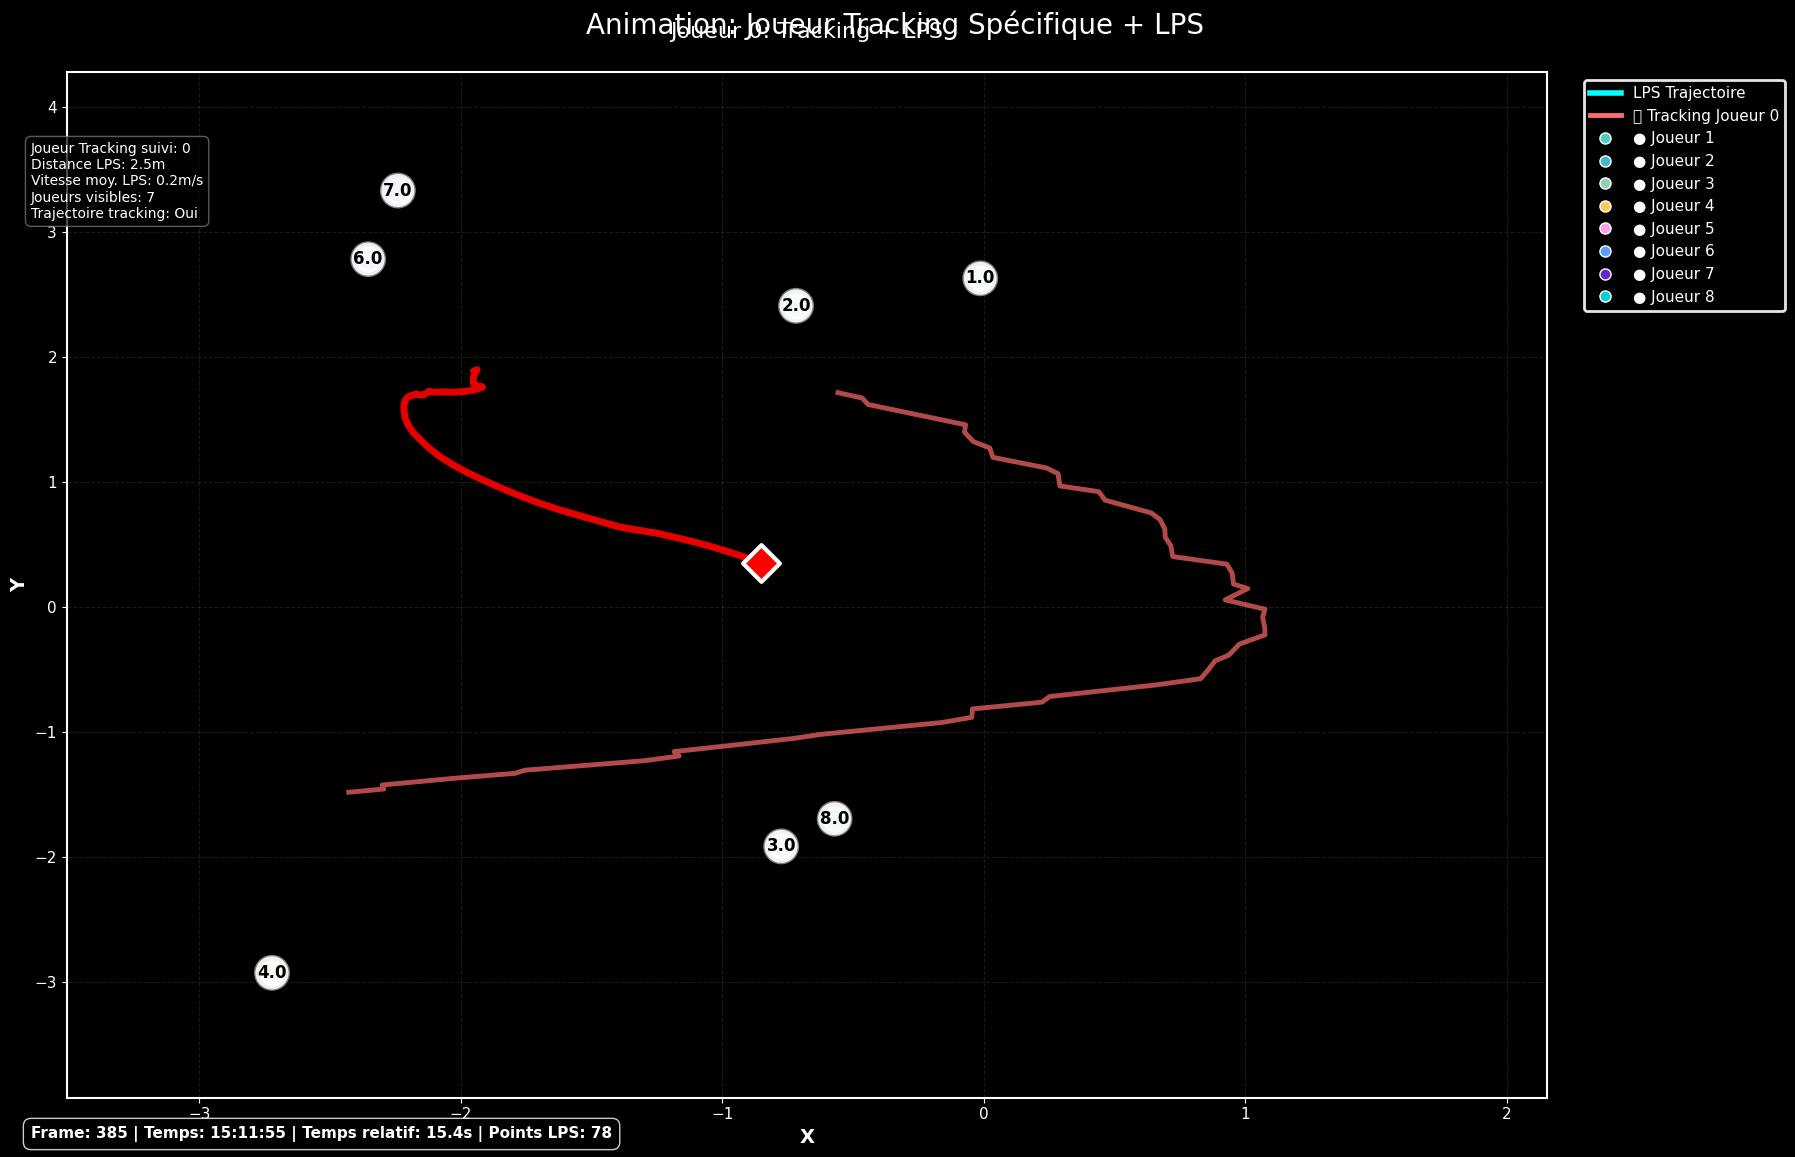

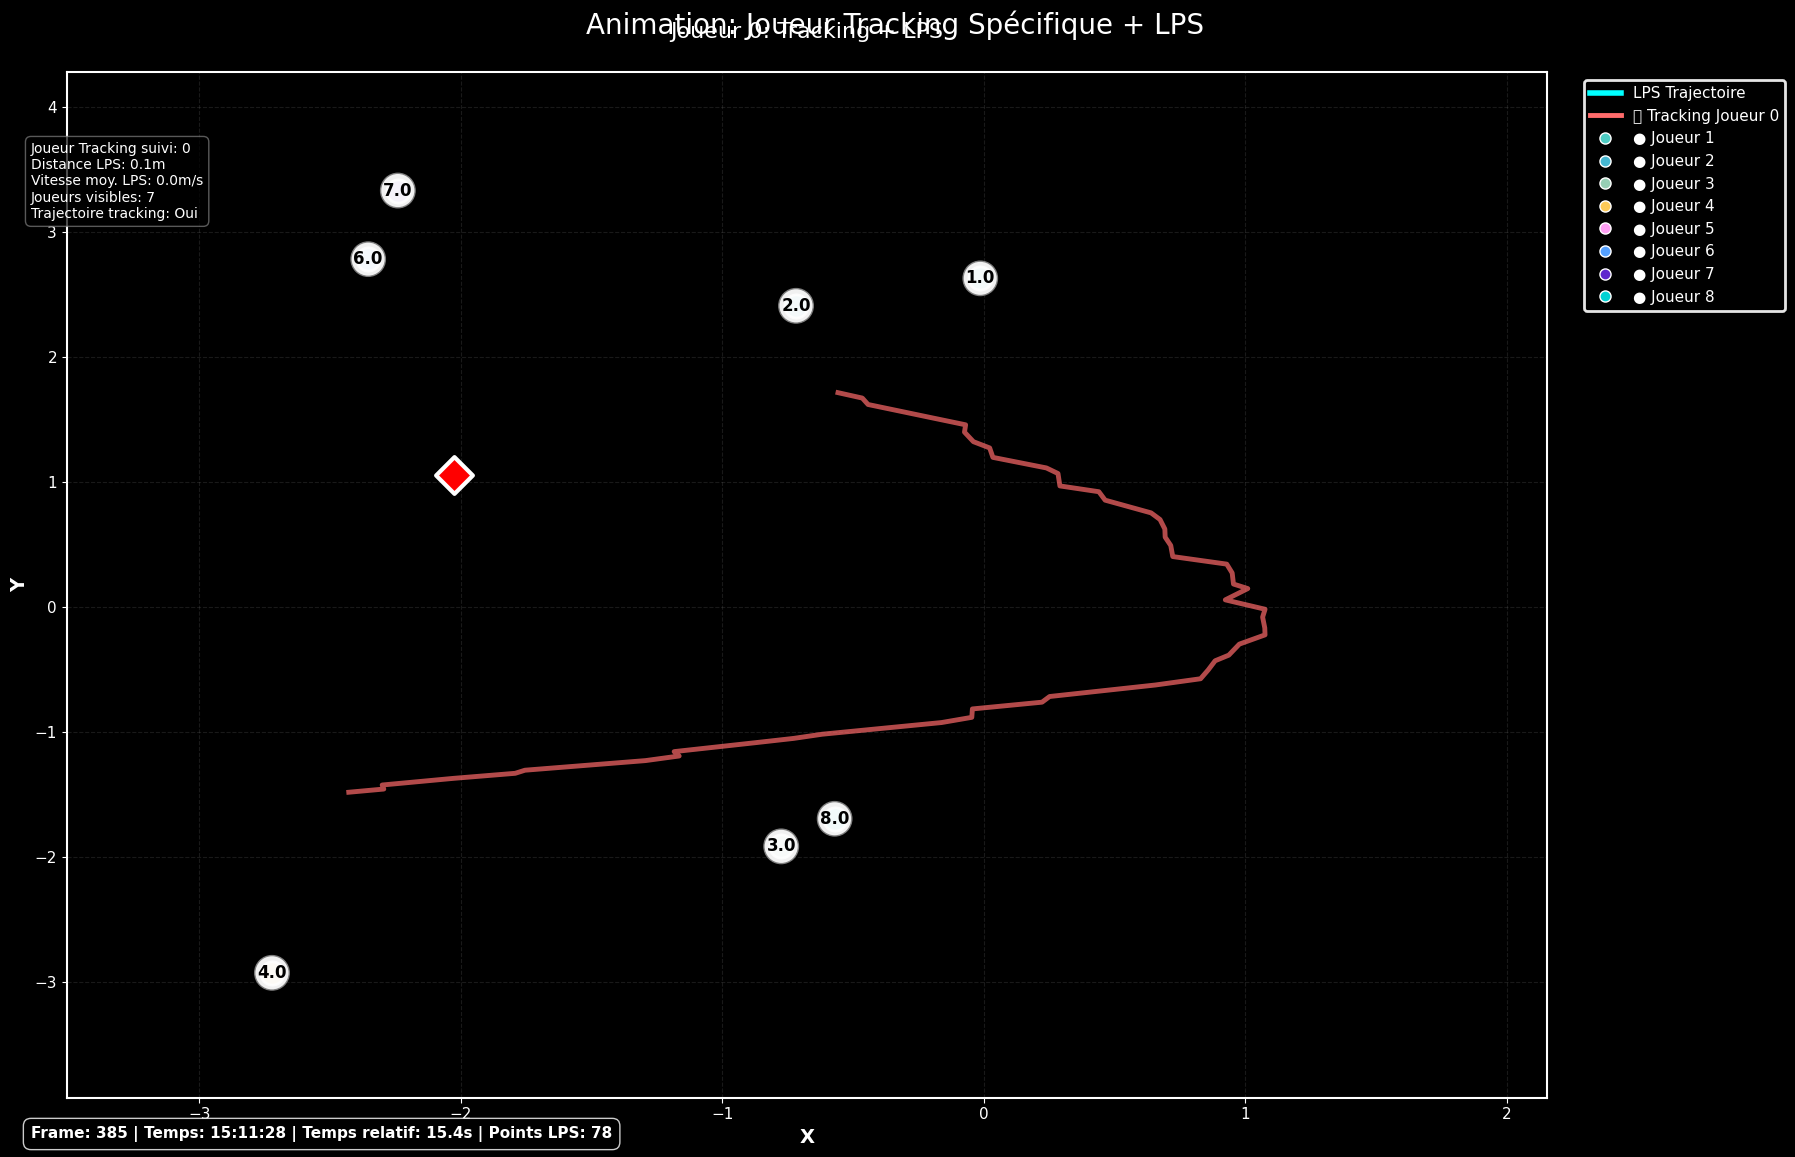

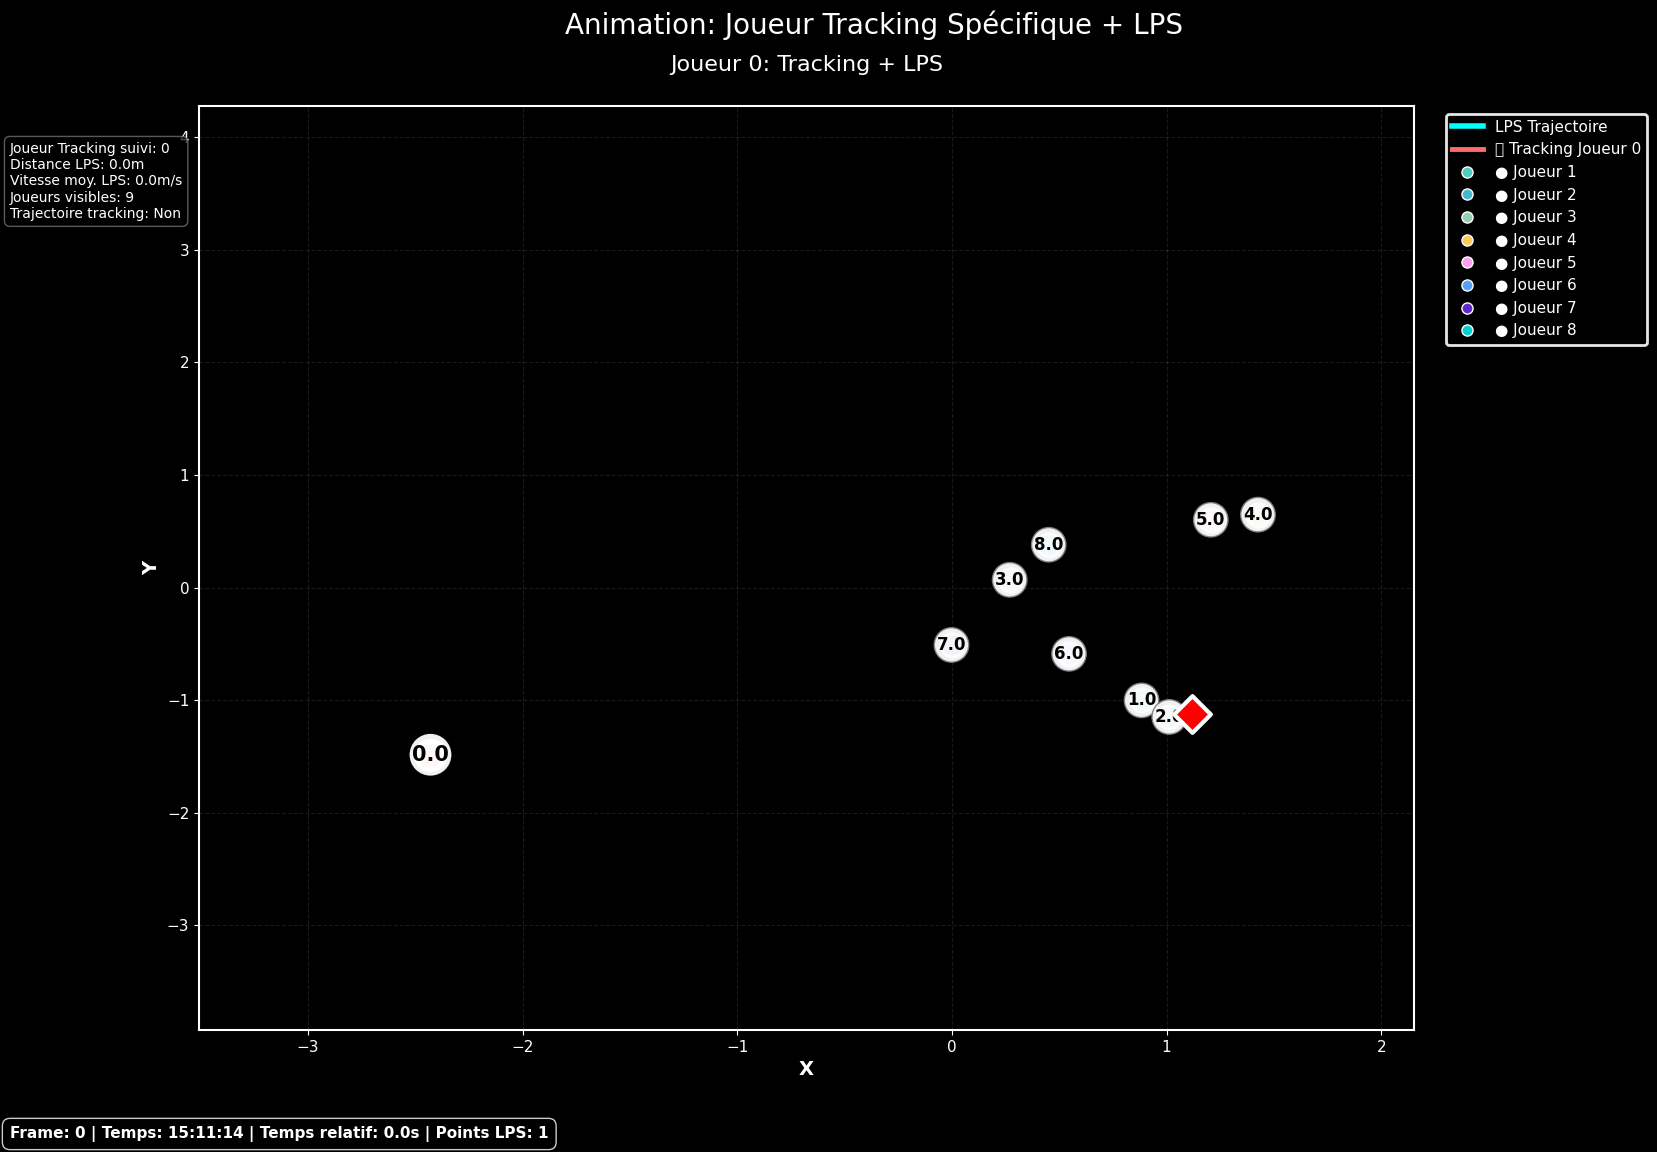

In [69]:
from video_basket import create_tracking_animation
create_tracking_animation(tracking_df, lps_dict[0], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_0_joueur_3.gif")
create_tracking_animation(tracking_df, lps_dict[1], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_1_joueur_8.gif")
create_tracking_animation(tracking_df, lps_dict[2], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_3_joueur_2.gif")
create_tracking_animation(tracking_df, lps_dict[3], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_4_joueur_1.gif")
create_tracking_animation(tracking_df, lps_dict[4], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_5_joueur_7.gif")
create_tracking_animation(tracking_df, lps_dict[5], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_7_joueur_6.gif")
create_tracking_animation(tracking_df, lps_dict[6], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_8_joueur_5.gif")
create_tracking_animation(tracking_df, lps_dict[7], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_10_joueur_4.gif")
create_tracking_animation(tracking_df, lps_dict[8], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_15_joueur_0.gif")
create_tracking_animation(tracking_df, lps_dict[9], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_16_joueur_3.gif")  
create_tracking_animation(tracking_df, lps_dict[10], t0=2160.4, output_filename="C:/Users/Ousmane Kontao/Desktop/Projet_Data/DATABASE/animation/lps_21_joueur_8.gif")